In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from category_encoders import BinaryEncoder, TargetEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from category_encoders import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
!pip install --upgrade scikit-learn
!pip install --upgrade imbalanced-learn
from imblearn.over_sampling import SMOTE   

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1. Чтение данных

In [7]:
df = pd.read_csv('..\.\data\loan_data.csv')

In [8]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [5]:
df.shape

(45000, 14)

In [6]:
df.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

# 2. Исследовательский анализ данных (EDA)

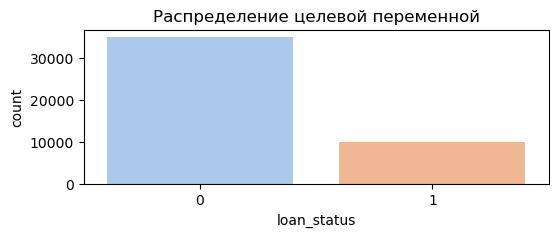

In [7]:
plt.figure(figsize=(6,2))
sns.countplot(x="loan_status", data=df, palette='pastel')
plt.title('Распределение целевой переменной')
plt.show()

В датасете присутствует дисбаланс классов, учтем это при обучении модели

In [8]:
numeric_factors = df.select_dtypes(include=['int64', 'float64']).columns
cat_factors = df.select_dtypes(include=['object']).columns

In [9]:
def categorical_bar_charts(df, columns, titles=None, max_cols=2):
    n = len(columns)
    rows = (n + max_cols - 1) // max_cols

    plt.figure(figsize=(5 * max_cols, 4 * rows))

    for i, col in enumerate(columns):
        plt.subplot(rows, max_cols, i + 1)
        sns.countplot(data=df, x=col, palette='pastel', order=df[col].value_counts().index)
        plt.title(titles[i] if titles else col)
        plt.xticks(rotation=45)
        plt.xlabel("")
        plt.ylabel("Count")

    plt.tight_layout()
    plt.suptitle("Распределение категориальных факторов", fontsize=16, y=1.02)
    plt.show()

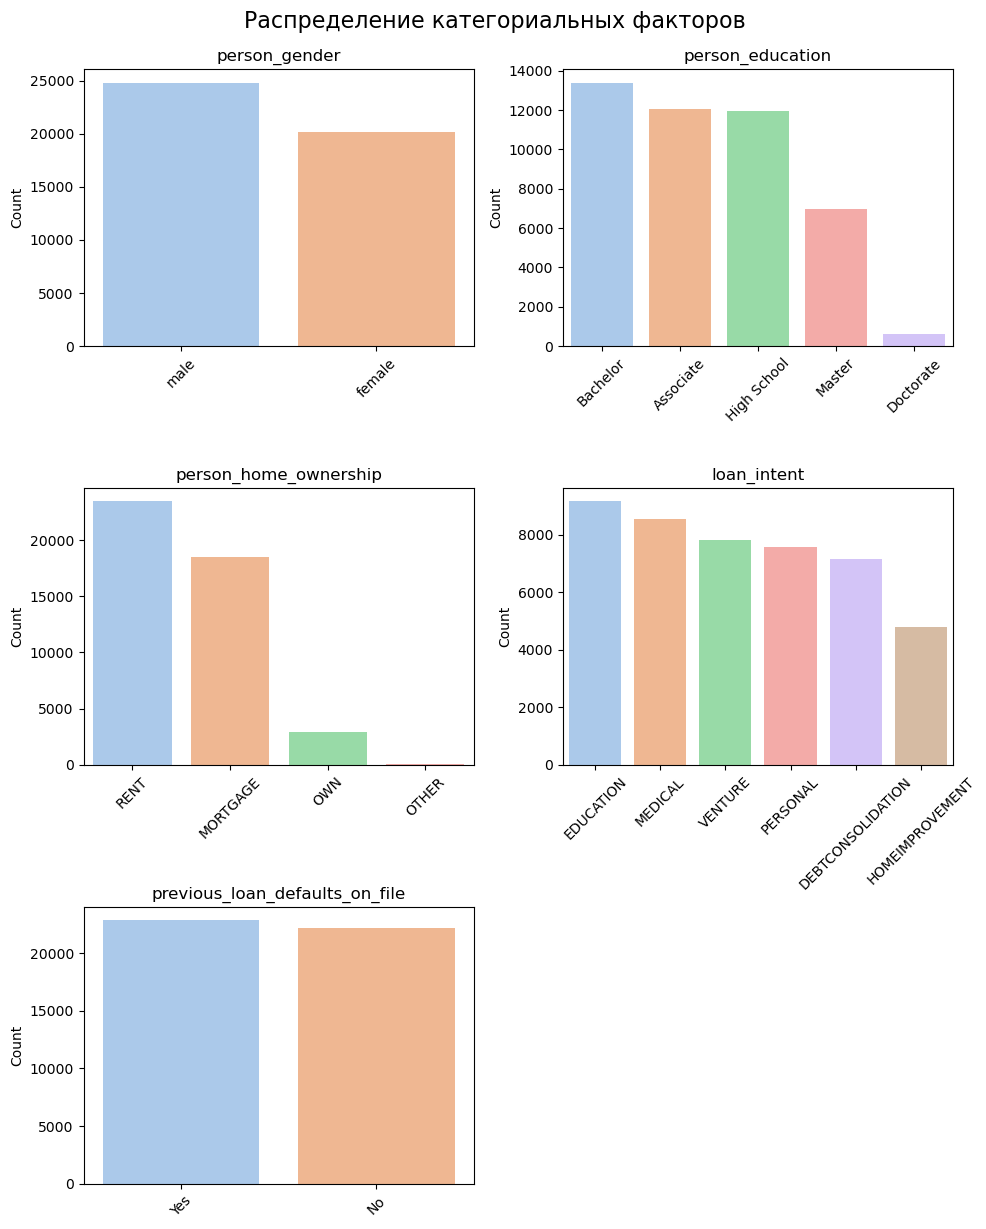

In [10]:
categorical_bar_charts(df, cat_factors)

In [11]:
def numeric_bar_charts(df, columns, titles=None, max_cols=2):
    n = len(columns)
    rows = (n + max_cols - 1) // max_cols

    plt.figure(figsize=(5 * max_cols, 4 * rows))

    for i, col in enumerate(columns):
        plt.subplot(rows, max_cols, i + 1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(titles[i] if titles else col)

    plt.tight_layout()
    plt.suptitle("Распределение числовых факторов", fontsize=16, y=1.02)
    plt.show()

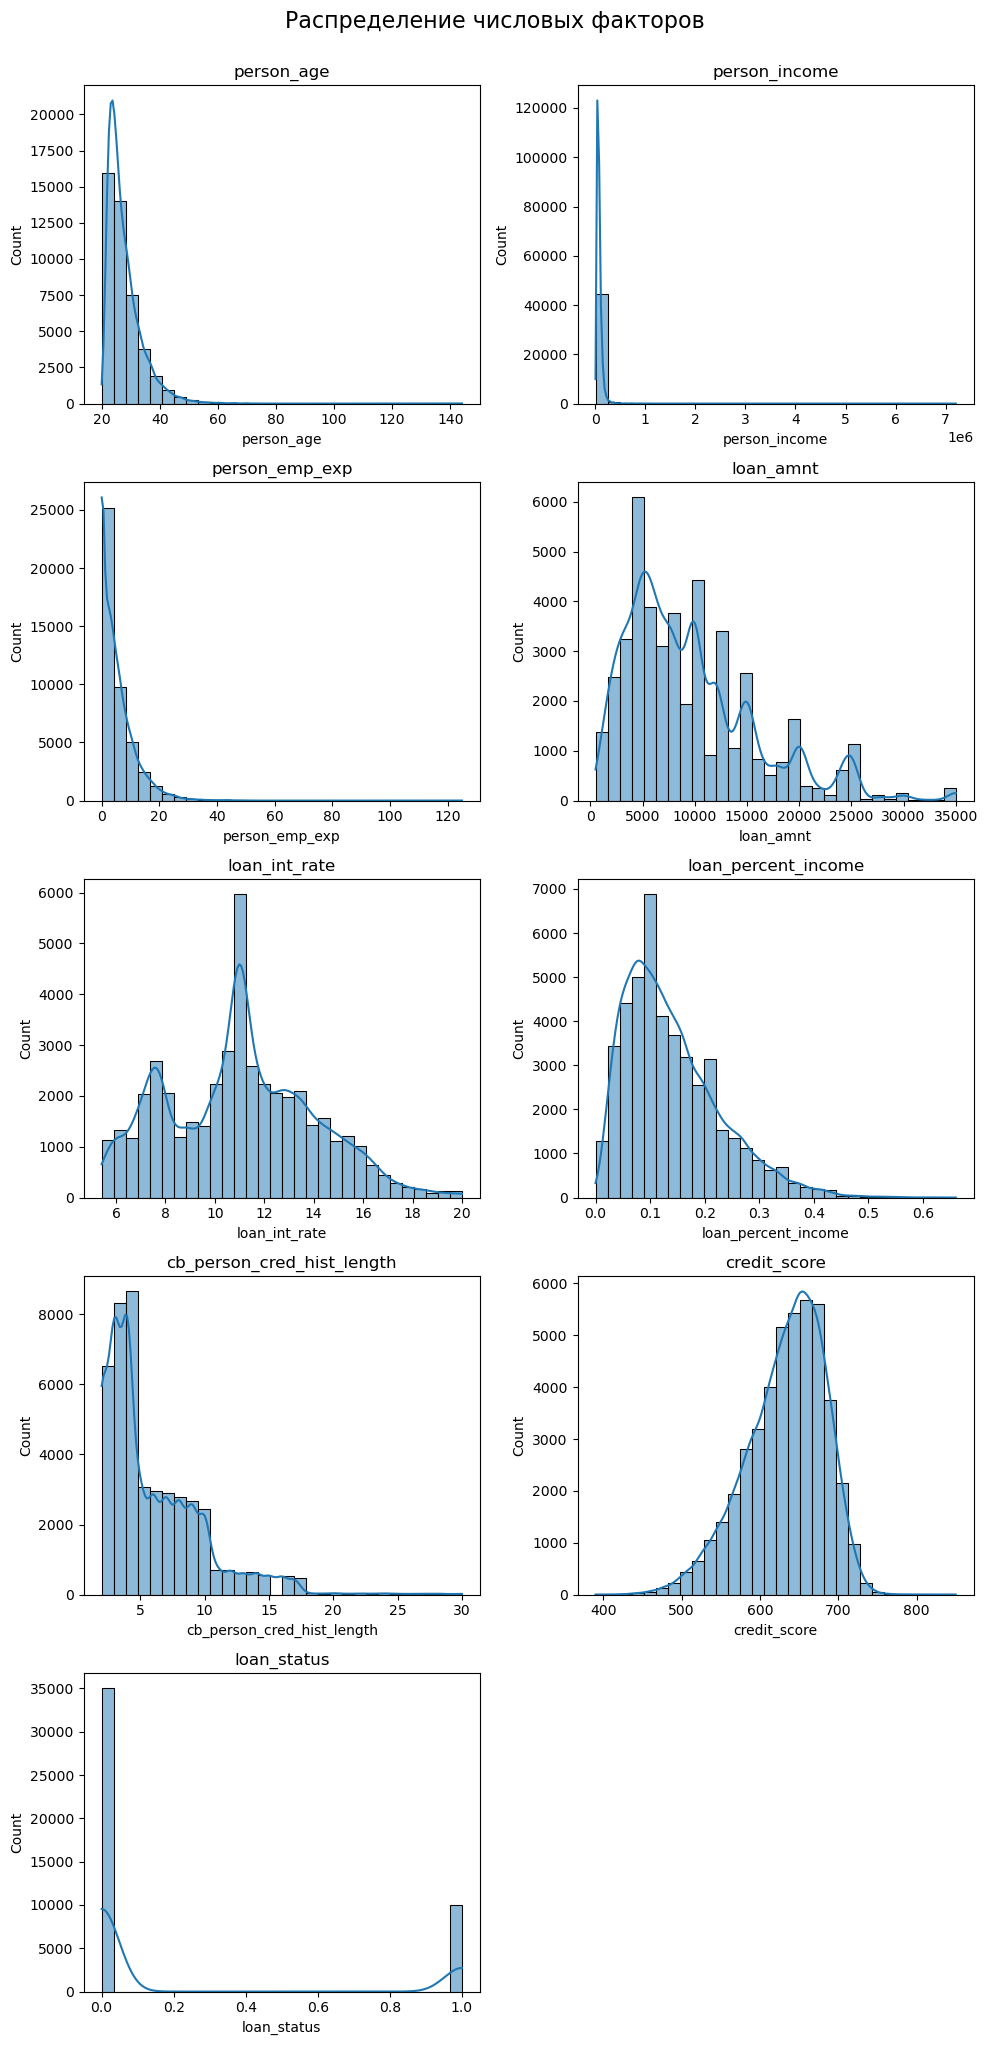

In [12]:
numeric_bar_charts(df, numeric_factors)

Исследуем числовые факторы на выбросы и аномальные значения

In [13]:
def numeric_boxplot_analysis(df, column):
    plt.figure(figsize=(10,2))

    sns.boxplot(x=df[column])
    plt.title(column)

    plt.tight_layout()
    plt.show()

    print(df[column].describe())

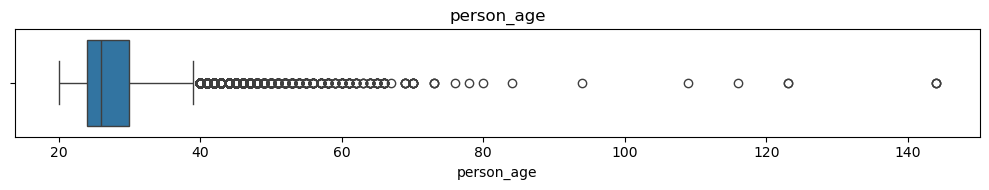

count    45000.000000
mean        27.764178
std          6.045108
min         20.000000
25%         24.000000
50%         26.000000
75%         30.000000
max        144.000000
Name: person_age, dtype: float64


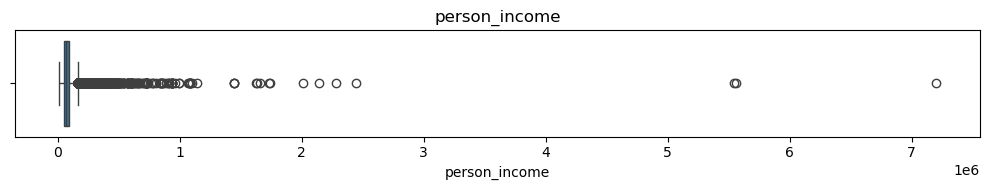

count    4.500000e+04
mean     8.031905e+04
std      8.042250e+04
min      8.000000e+03
25%      4.720400e+04
50%      6.704800e+04
75%      9.578925e+04
max      7.200766e+06
Name: person_income, dtype: float64


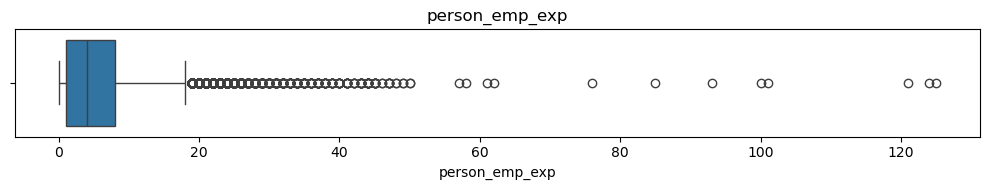

count    45000.000000
mean         5.410333
std          6.063532
min          0.000000
25%          1.000000
50%          4.000000
75%          8.000000
max        125.000000
Name: person_emp_exp, dtype: float64


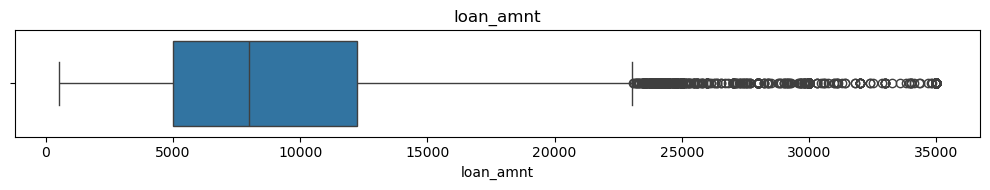

count    45000.000000
mean      9583.157556
std       6314.886691
min        500.000000
25%       5000.000000
50%       8000.000000
75%      12237.250000
max      35000.000000
Name: loan_amnt, dtype: float64


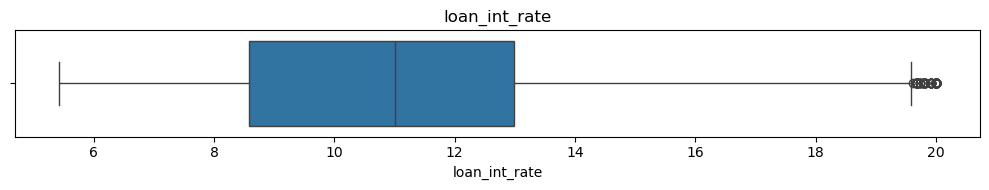

count    45000.000000
mean        11.006606
std          2.978808
min          5.420000
25%          8.590000
50%         11.010000
75%         12.990000
max         20.000000
Name: loan_int_rate, dtype: float64


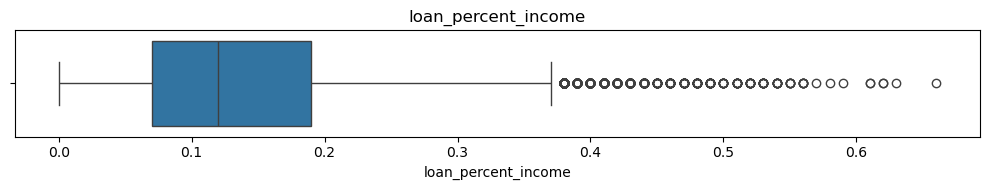

count    45000.000000
mean         0.139725
std          0.087212
min          0.000000
25%          0.070000
50%          0.120000
75%          0.190000
max          0.660000
Name: loan_percent_income, dtype: float64


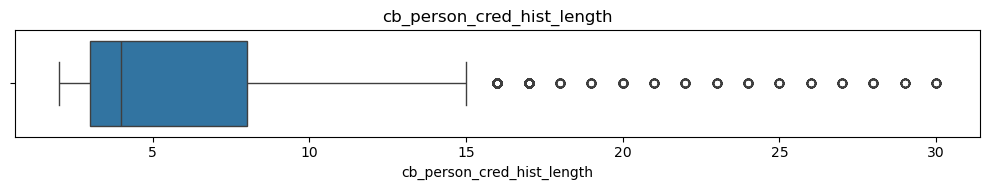

count    45000.000000
mean         5.867489
std          3.879702
min          2.000000
25%          3.000000
50%          4.000000
75%          8.000000
max         30.000000
Name: cb_person_cred_hist_length, dtype: float64


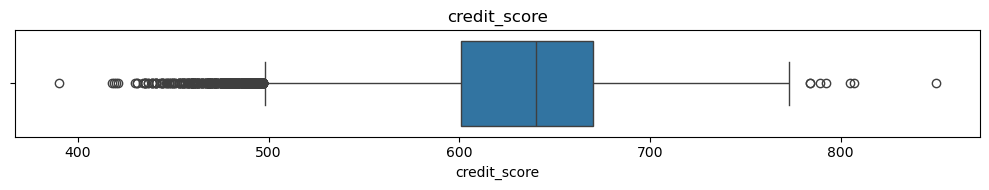

count    45000.000000
mean       632.608756
std         50.435865
min        390.000000
25%        601.000000
50%        640.000000
75%        670.000000
max        850.000000
Name: credit_score, dtype: float64


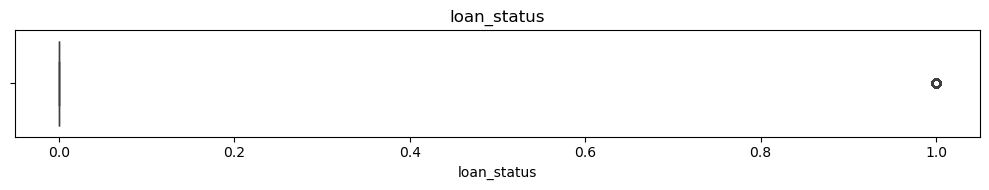

count    45000.000000
mean         0.222222
std          0.415744
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: loan_status, dtype: float64


In [14]:
for col in numeric_factors:
    numeric_boxplot_analysis(df, col)


Фактор ```person_age``` содержит выбросы, принимающие значения от 100 до 144

In [15]:
age_median = df['person_age'].median()
df['person_age'] = df['person_age'].apply(lambda x: age_median if x > 100 else x)
df['person_age'].describe()

count    45000.000000
mean        27.748156
std          5.909318
min         20.000000
25%         24.000000
50%         26.000000
75%         30.000000
max         94.000000
Name: person_age, dtype: float64

In [16]:
unique_counts = df[cat_factors].nunique().sort_values(ascending=False)
print(unique_counts)

loan_intent                       6
person_education                  5
person_home_ownership             4
person_gender                     2
previous_loan_defaults_on_file    2
dtype: int64


### Исследование признаков на корреляцию

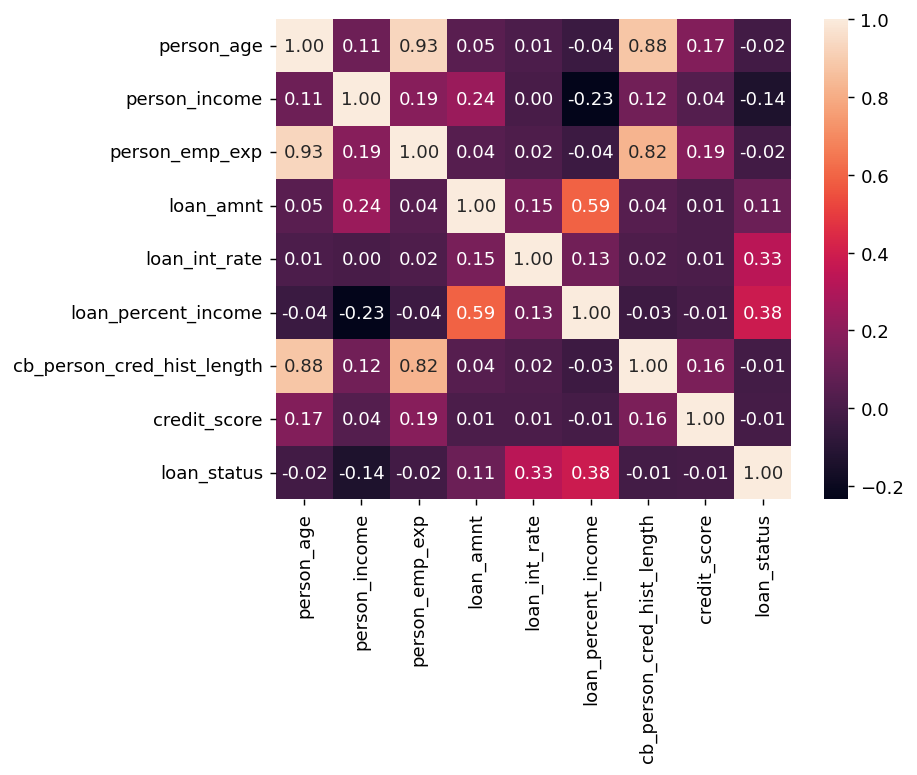

In [17]:
corr = df[numeric_factors].corr()

plt.figure(dpi=130)
sns.heatmap(corr, annot=True, fmt= '.2f')
plt.show()

<Axes: xlabel='person_emp_exp', ylabel='person_age'>

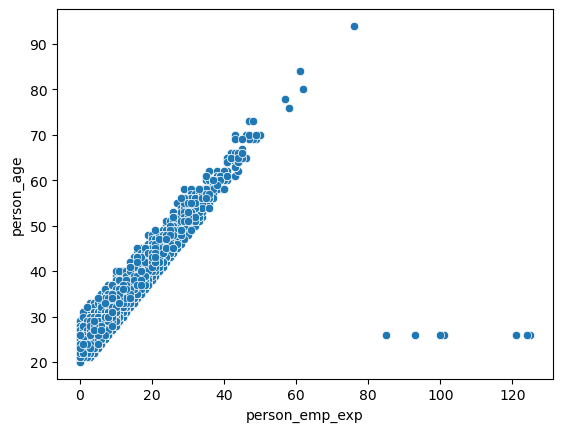

In [18]:
sns.scatterplot(x = 'person_emp_exp', y = 'person_age', data=df)

# 3. Подготовка данных

In [19]:
X = df.drop('loan_status', axis=1)  
y = df['loan_status'] 



numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

In [20]:
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
preprocessed_X_train = preprocessor.fit_transform(X_train)
preprocessed_X_test = preprocessor.transform(X_test)

In [22]:
smote = SMOTE(random_state=42)
preprocessed_X_train, y_train = smote.fit_resample(preprocessed_X_train, y_train)

# 4. Обучение модели

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

##### LogisticRegression

In [24]:
param_grid_lr = [
    {'penalty':['l1','l2','elasticnet','none'],
    'C' : np.logspace(-4,4,20),
    'solver': ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter'  : [100,250,500]
}
]

lr_model = LogisticRegression()
grid_search = GridSearchCV(lr_model, param_grid_lr, scoring='roc_auc', cv=5)
grid_search.fit(preprocessed_X_train, y_train)

,estimator,LogisticRegression()
,param_grid,"[{'C': array([1.0000...00000000e+04]), 'max_iter': [100, 250, ...], 'penalty': ['l1', 'l2', ...], 'solver': ['lbfgs', 'newton-cg', ...]}]"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [25]:
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'C': 0.08858667904100823, 'max_iter': 250, 'penalty': 'l1', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.9561688775510204


In [29]:
best_lr_model = grid_search.best_estimator_
y_pred = best_lr_model.predict(preprocessed_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7000
           1       0.63      0.92      0.75      2000

    accuracy                           0.86      9000
   macro avg       0.80      0.88      0.83      9000
weighted avg       0.90      0.86      0.87      9000



##### DecisionTreeClassifier

In [30]:
param_grid_dtc = {
    'max_depth':  np.arange(1, 30)
}

dtc_model = DecisionTreeClassifier()
grid_search = GridSearchCV(dtc_model, param_grid_dtc, scoring='roc_auc', cv=5)
grid_search.fit(preprocessed_X_train, y_train)

,estimator,DecisionTreeClassifier()
,param_grid,"{'max_depth': array([ 1, 2..., 27, 28, 29])}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [31]:
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': 9}
Best Cross-Validation Score: 0.969333781887755


In [32]:
best_dtc_model = grid_search.best_estimator_
y_pred = best_dtc_model.predict(preprocessed_X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      7000
           1       0.70      0.86      0.77      2000

    accuracy                           0.89      9000
   macro avg       0.83      0.88      0.85      9000
weighted avg       0.90      0.89      0.89      9000



##### RandomForestClassifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
param_grid_rfc = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

rfc_model = RandomForestClassifier()
grid_search = GridSearchCV(rfc_model, param_grid_rfc, scoring='roc_auc', cv=5)
grid_search.fit(preprocessed_X_train, y_train)

,estimator,RandomForestClassifier()
,param_grid,"{'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,150


In [35]:
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 150}
Best Cross-Validation Score: 0.9919013360969388


In [36]:
best_rfc_model = grid_search.best_estimator_

y_test_pred = best_rfc_model.predict(preprocessed_X_test)
y_test_pred_proba = best_rfc_model.predict_proba(preprocessed_X_test)[:, 1]

In [37]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      7000
           1       0.80      0.84      0.82      2000

    accuracy                           0.92      9000
   macro avg       0.88      0.89      0.89      9000
weighted avg       0.92      0.92      0.92      9000



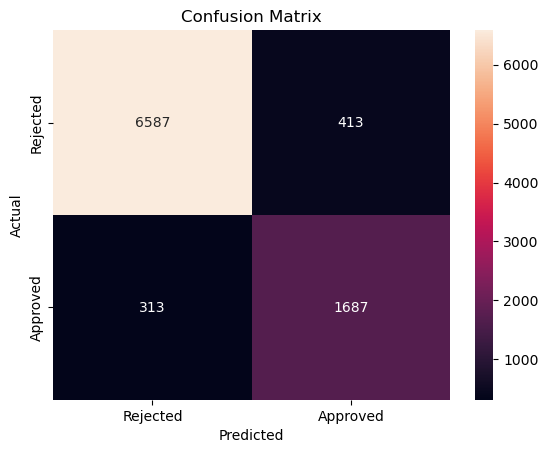

In [38]:
from sklearn.metrics import confusion_matrix


conf_matrix = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')  

plt.xlabel('Predicted')
plt.ylabel('Actual')  
plt.xticks(np.arange(2) + 0.5, ['Rejected', 'Approved']) 
plt.yticks(np.arange(2) + 0.5, ['Rejected', 'Approved'])  
plt.title('Confusion Matrix') 

plt.show()

##### XGBClassifier

In [39]:
import xgboost

In [40]:
xgbc_model = xgboost.XGBClassifier(n_estimators=500)


xgbc_model.fit(preprocessed_X_train, y_train)

y_train_predicted = xgbc_model.predict_proba(preprocessed_X_train)[:, 1]
y_test_predicted = xgbc_model.predict_proba(preprocessed_X_test)[:, 1]
y_pred = xgbc_model.predict(preprocessed_X_test)

In [41]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

In [42]:
print(test_auc)

0.9781580714285715


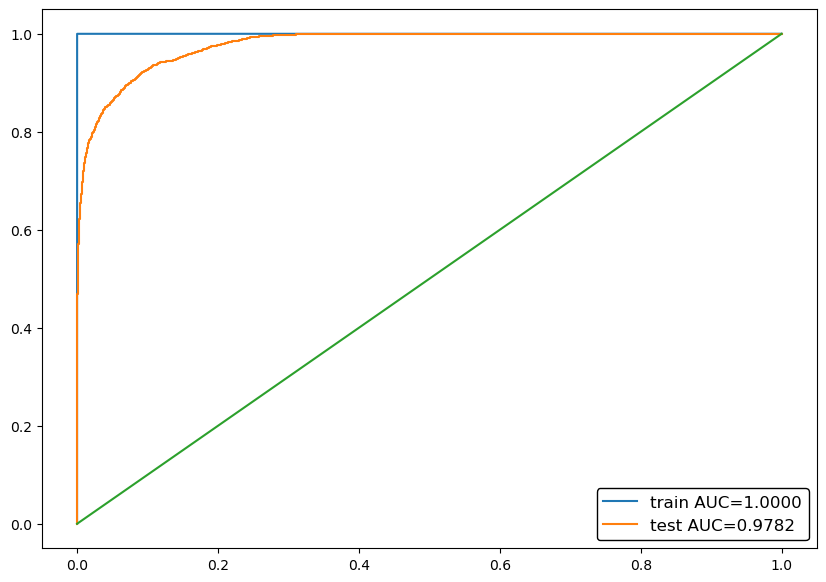

In [43]:
from sklearn.metrics import roc_curve


plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      7000
           1       0.87      0.84      0.85      2000

    accuracy                           0.94      9000
   macro avg       0.91      0.90      0.91      9000
weighted avg       0.94      0.94      0.94      9000



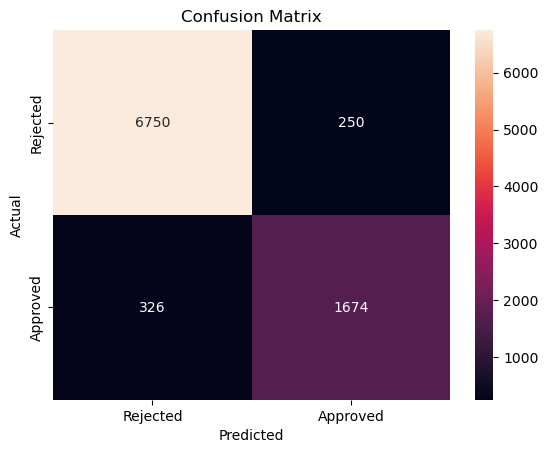

In [45]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')  

plt.xlabel('Predicted')
plt.ylabel('Actual')  
plt.xticks(np.arange(2) + 0.5, ['Rejected', 'Approved']) 
plt.yticks(np.arange(2) + 0.5, ['Rejected', 'Approved'])  
plt.title('Confusion Matrix') 

plt.show()